# GAGAG clusters based on nucleosome (iNPS) boundaries and gap sizes

In [2]:
import pandas as pd
import pyBigWig
import numpy as np
from progressbar import progressbar
from matplotlib import pyplot as plt
import pyranges as pr

In [38]:
# selected chromosomes
selectChroms = ['chr2L', 'chr2R', 'chr3L', 'chr3R', 'chr4', 'chrX']
# read in nucleosome positions (by iNPS from whole genome, liftovered from dm3 to dm6)
nucleosomes = pr.read_bed("./dmNuc0210501.iNPSPeak.liftover.dm6.bed")
# read in CHIP-seq data. It also contains the size of chromosomes
ChipSeq = pyBigWig.open("GSM4759765_GAFRNAi_GAFChIP_Rep2.bw")
# extract chromosome sizes
chromSizes = {chr:ChipSeq.chroms(chr) for chr in selectChroms}
# read in gagag motifs
gagag = pr.read_bed("GAGAG_dm6.bed")

Goals:
1. find clusters of gagag sites
    - size of motifs
    - gaps between consequtive motifs
    - Use nucleosomes as boundaries
2. test the correlation between the size of gagag clusters and Chip intensities

In [61]:
class ClusterAnalysis:
    """Analyze clusters of motifs on a chromosome.
    Attributes:
    -----------
    motifs : pd.DataFrame
        DataFrame containing motif information with columns 'Chromosome', 'Start', and 'End'.
    chromosome : str
        The chromosome to analyze.
    gap_size : int
        The maximum gap size between motifs to consider them part of the same cluster.
    cluster_sizes : list
        List containing the sizes of each cluster.
    motif_sizes : list
        List of lists containing the sizes of motifs within each cluster.
    cluster_gaps : list
        List of lists containing the gaps between motifs within each cluster.
    Methods:
    --------
    _calculate_clusters():
        Private method to calculate clusters based on the gap size.
    get_motif_sizes():
        Returns the sizes of motifs within each cluster.
    get_cluster_gaps():
        Returns the gaps between motifs within each cluster.
    get_cluster_sizes():
        Returns the sizes of each cluster.
    """

    def __init__(self, motifs:pd.DataFrame, chromosome:str, gap_size:int):
        """Initialize the ClusterAnalysis object.
        Parameters:
        -----------
        motifs : pd.DataFrame
            DataFrame containing motif information with columns 'Chromosome', 'Start', and 'End'.
        chromosome : str
            The chromosome to analyze.
        gap_size : int
            The maximum gap size between motifs to consider them part of the same cluster.
        """
        self.motifs = motifs[motifs['Chromosome'] == chromosome].sort_values(by='Start')
        self.chromosome = chromosome
        self.gap_size = gap_size
        self.cluster_sizes = []
        self.motif_sizes = []
        self.cluster_gaps = []
        self._calculate_clusters()

    def _calculate_clusters(self):

        clusters = []
        current_cluster = []
        previous_end = None
        
        for _, row in self.motifs.iterrows():
            start = row['Start']
            end = row['End']
            if previous_end is None:
                current_cluster.append({'Start': start, 'End': end})
            elif start - previous_end <= self.gap_size:
                if start - previous_end <= 0:
                    current_cluster[-1]['End'] = max(current_cluster[-1]['End'], end)
                else:
                    current_cluster.append({'Start': start, 'End': end})
            else:
                clusters.append(current_cluster)
                current_cluster = [{'Start': start, 'End': end}]
            previous_end = end
        
        if current_cluster:
            clusters.append(current_cluster)

        self.clusters = [Cluster(cluster) for cluster in clusters]

    def get_motif_sizes(self):
        return [cluster.motif_sizes for cluster in self.clusters]

    def get_cluster_gaps(self):
        return [cluster.gaps for cluster in self.clusters]
    
    def get_cluster_sizes(self):
        return [cluster.size for cluster in self.clusters]
    
    def get_cluster_positions(self, start:int, end:int):
        '''return an array where each element is 1 if the position is in a cluster, 0 otherwise'''
        positions = np.zeros(end+1 - start)
        for cluster in self.clusters:
            positions[cluster.start - start : cluster.end - start + 1] = 1
        return positions

    
    def __str__(self) -> str:
        return f"ClusterAnalysis({self.chromosome}, {self.gap_size})"
    
    def __repr__(self) -> str:
        return f"ClusterAnalysis({self.chromosome}, {self.gap_size})"

class Cluster:
    def __init__(self, motifs):
        self.motifs = motifs
        self.start = motifs[0]['Start']
        self.end = motifs[-1]['End']
        self.size = len(motifs)
        self.motif_sizes = [motif['End'] - motif['Start'] for motif in motifs]
        self.gaps = [motifs[i+1]['Start'] - motifs[i]['End'] for i in range(len(motifs) - 1)]

    def __str__(self):
        return f"Cluster(start={self.start}, end={self.end}, size={self.size}, motif_sizes={self.motif_sizes}, gaps={self.gaps})"

    def __repr__(self):
        return self.__str__()
    

In [62]:
# Example usage
chromosome = 'chr2L'
gap_size = 30
analysis = ClusterAnalysis(gagag.df, chromosome, gap_size)

In [ ]:
ChipSeq.values("chr2L", 0, 1000)

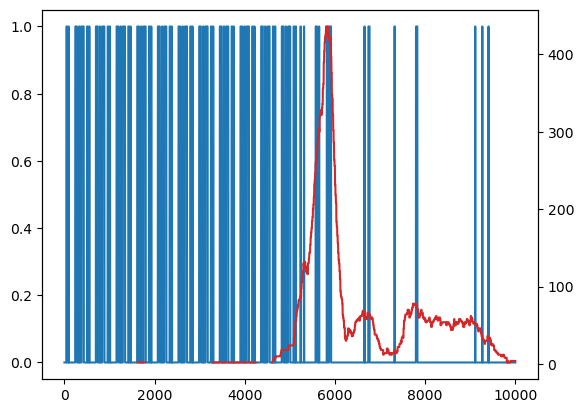

In [67]:
plt.plot(analysis.get_cluster_positions(0, 10000))
plt.twinx()
plt.plot(ChipSeq.values(chromosome, 0, 10000), color='tab:red')

(array([2.4722e+04, 1.6330e+03, 3.2100e+02, 7.3000e+01, 1.0000e+01,
        4.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 <BarContainer object of 8 artists>)

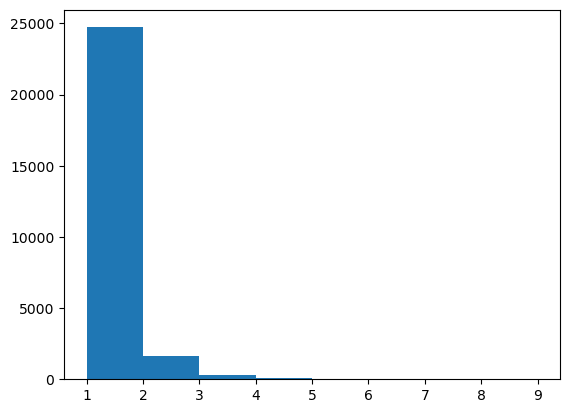

In [63]:
plt.hist(analysis.get_cluster_sizes(), bins=range(1, 10))